In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#os.chdir("drive/My Drive/dataset-resized")

#data_dir  = 'content/drive/My Drive/dataset-resized'

#classes = os.listdir(data_dir)
#print(classes)

data_dir = "/content/drive/My Drive/Colab Notebooks/dataset-resized"
classes = os.listdir(data_dir)

print(classes)

['.DS_Store', 'metal', 'paper', 'glass', 'cardboard', 'plastic', 'trash']


In [4]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

transformations

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [5]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))
  

Label: cardboard (Class No: 0)


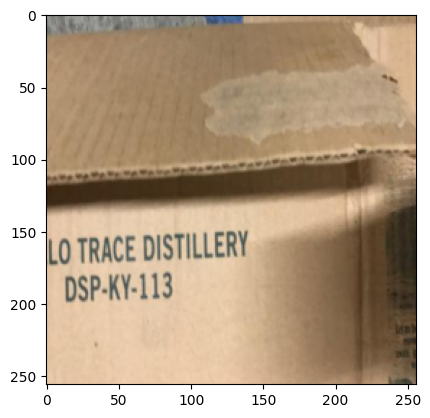

In [6]:
img, label = dataset[12]
show_sample(img, label)

In [7]:
#Load + Splitting Data

random_seed = 42
torch.manual_seed(random_seed)

In [8]:
#Split into training, validation and test sets

train_ds, val_ds, test_ds = random_split(dataset, [1593, 182, 758])
len(train_ds), len(val_ds), len(test_ds)

batch_size = 32

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


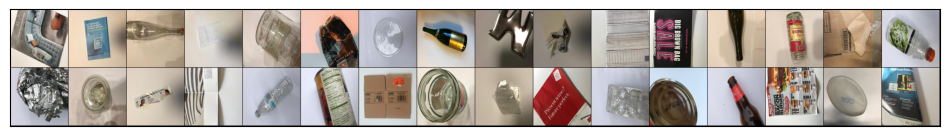

In [10]:
show_batch(train_dl)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(weights=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = to_device(ResNet(), device)
evaluate(model, val_dl)


{'val_loss': 1.7808164358139038, 'val_acc': 0.2322530746459961}

In [21]:
num_epochs = 24
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.0486, val_loss: 1.1275, val_acc: 0.9080
Epoch 2: train_loss: 1.0502, val_loss: 1.1411, val_acc: 0.8966
Epoch 3: train_loss: 1.0511, val_loss: 1.1475, val_acc: 0.8933
Epoch 4: train_loss: 1.0481, val_loss: 1.1463, val_acc: 0.8933
Epoch 5: train_loss: 1.0490, val_loss: 1.1260, val_acc: 0.9161
Epoch 6: train_loss: 1.0473, val_loss: 1.1330, val_acc: 0.9037
Epoch 7: train_loss: 1.0459, val_loss: 1.1354, val_acc: 0.9028
Epoch 8: train_loss: 1.0457, val_loss: 1.1279, val_acc: 0.9142
Epoch 9: train_loss: 1.0474, val_loss: 1.1288, val_acc: 0.9161
Epoch 10: train_loss: 1.0485, val_loss: 1.1303, val_acc: 0.9028
Epoch 11: train_loss: 1.0472, val_loss: 1.1321, val_acc: 0.9099
Epoch 12: train_loss: 1.0483, val_loss: 1.1767, val_acc: 0.8706
Epoch 13: train_loss: 1.0484, val_loss: 1.1353, val_acc: 0.8985
Epoch 14: train_loss: 1.0506, val_loss: 1.1900, val_acc: 0.8468
Epoch 15: train_loss: 1.0495, val_loss: 1.1222, val_acc: 0.9109
Epoch 16: train_loss: 1.0473, val_loss: 1.1241, v

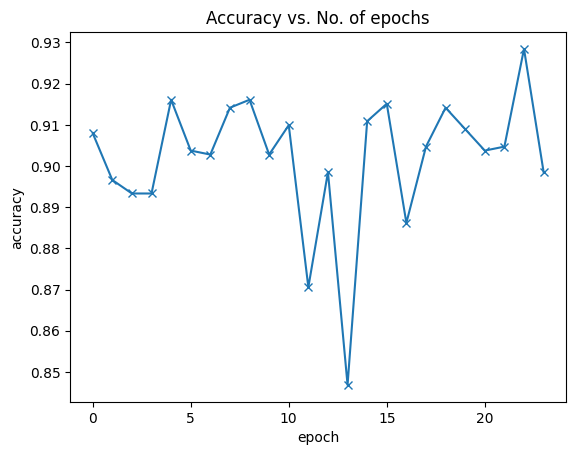

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

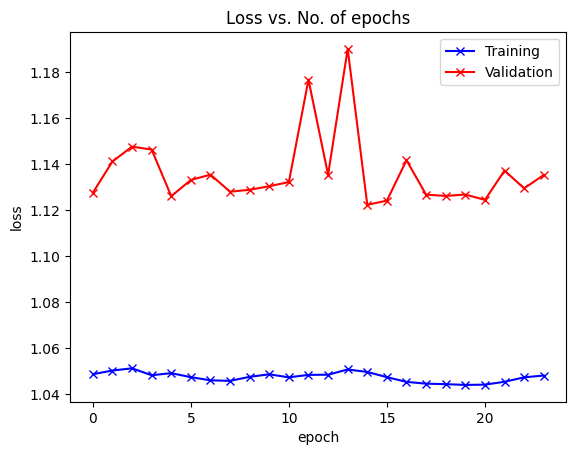

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: cardboard , Predicted: cardboard


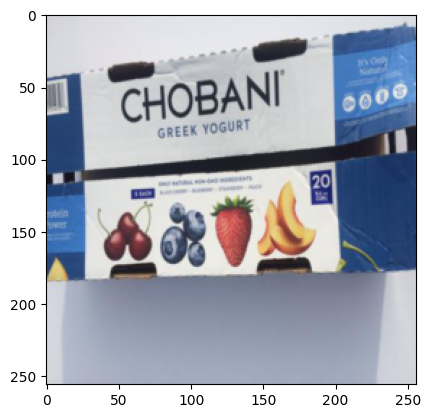

In [27]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


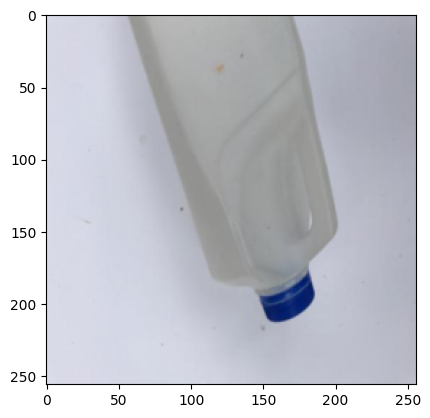

In [29]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


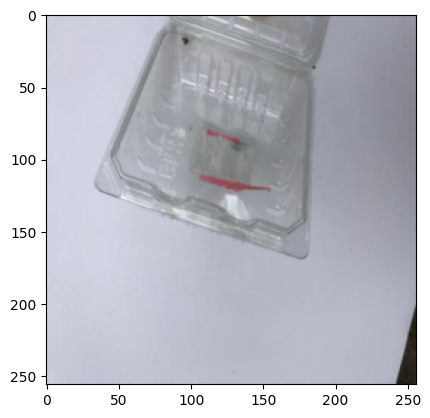

In [30]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))